U-net architecture  is designed for semantic segmentation

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style
from collections import OrderedDict
import numpy as np
import nibabel as nib
from torch.utils.data import DataLoader , TensorDataset, SubsetRandomSampler, random_split


In [2]:
MODEL_NAME = f"model-{(time.asctime())}"  # gives a dynamic model name, to just help with things getting messy over
# time.

#IMG_SIZE = None
EPOCHS = 20
VAL_PCT = 0.4
LR = 0.001
PT = 'D:/projects/Neural_Networks/coursera_v2/coursera/model/model000.pt'
PT_ = 'D:/projects/Neural_Networks/coursera_v3/coursera/model/model.pt'
#PATH_TO_DATA = None
BATCH_SIZE = 10

In [3]:
pathImgs, pathMasks = 'D:/projects/Neural_Networks/research/datasets/covid19/tr_im.nii/tr_im.nii', 'D:/projects/Neural_Networks/research/datasets/covid19/tr_mask.nii/tr_mask.nii' #enter the filepath of CT images and masks   

In [4]:
imgRaw, maskRaw = nib.load(pathImgs), nib.load(pathMasks)

In [5]:
img, mask = np.asanyarray(imgRaw.dataobj), np.asanyarray(maskRaw.dataobj) #converting dataset to numpy ndarrays
print('Dataset loaded')

Dataset loaded


In [6]:
img_ = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

mask_ = cv2.resize(mask, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

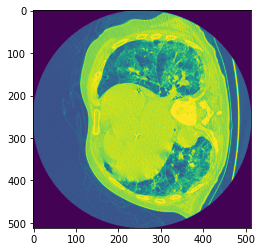

In [7]:
plt.imshow(img[:,:,0])

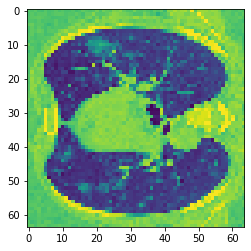

In [8]:
plt.imshow(img_[:,:,4])

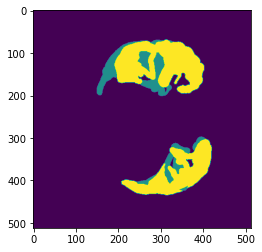

In [9]:
plt.imshow(mask[:,:,0])

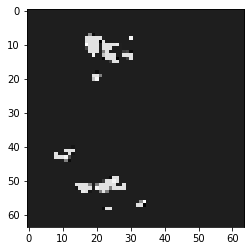

In [10]:
plt.imshow(mask_[:,:,4], cmap='gray')

In [11]:
data = []
data.append([np.array(img_), np.array(mask_)])

np.random.shuffle(data)
np.save("D:\\projects\\Neural_Networks\\research\\datasets\\covid19\\data.npy",data)

#img, mask = img.reshape(512,512,100,-1), mask.reshape(512,512,100,-1) #adding channel dimension
#img, mask = np.transpose(img,(2,0,1,3)), np.transpose(mask,(2,0,1,3)) #reordering arrays



In [12]:

data = np.load("D:\\projects\\Neural_Networks\\research\\datasets\\covid19\\data.npy", allow_pickle=True)


X = torch.Tensor([i[0] for i in data]) #.view(512,512,100,-1) #images
y = torch.Tensor([i[1] for i in data]) #.view(512,512,100,-1)#images



In [13]:
X, y = X / 255.00, y / 255.00

In [14]:
mask_[mask_ != 0] = 1

In [15]:
np.nonzero(y)

tensor([[ 0,  2, 30, 57],
        [ 0,  2, 31,  1],
        [ 0,  2, 31, 57],
        ...,
        [ 0, 60, 41, 72],
        [ 0, 61, 36, 43],
        [ 0, 61, 37, 72]])

In [20]:
print(X.shape, y.shape)

torch.Size([100, 1, 64, 64]) torch.Size([100, 1, 64, 64])


In [19]:
X, y = torch.transpose(X, 1, 3), torch.transpose(y,1, 3)
#X, y = torch.transpose(X, 1, 3), torch.transpose(y,1, 3)#reordering arrays

In [21]:
val_size = int(len(X) * VAL_PCT)
print(val_size)
print(len(X))
#creating data and train sets.

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

n = len(X) - val_size # iteration number
print(n)

40
100
60


In [22]:
t_dataset = TensorDataset(train_X , train_y)
train = DataLoader(t_dataset , batch_size = BATCH_SIZE, shuffle=True)

v_dataset = TensorDataset(test_X, test_y)
test = DataLoader(v_dataset, batch_size = BATCH_SIZE)


In [23]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on " + str(device) + ".")
else:
    device = torch.device("cpu")
    print("running on" + str(device) + ".")
# torch.cuda.device_count()


running on cuda:0.


In [24]:

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x


class input_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(input_conv, self).__init__()
        self.inp_conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        #print("input_conv_x_ent:" , x.shape)
        x = self.inp_conv(x)
        #print("input_conv_x_ext:" , x.shape)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        #print("up_x1_ent:" , x1.shape)
        x1 = self.up_conv(x1)
        #print("up_x1:" , x1.shape)
        #print("up_x2:" , x2.shape)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        #print("down_x_ent:" , x.shape)
        x = self.pool(x)
        x = self.conv(x)
        #print("down_x_ext:" , x.shape)
        return x


class last_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(last_conv, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv1(x)
        return x


class Unet(nn.Module):
    def __init__(self, channels, classes):
        super(Unet, self).__init__()
        self.inp = input_conv(channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 1024)
        self.up1 = up(1024, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 128)
        self.up4 = up(128, 64)
        self.out = last_conv(64, classes)

    def forward(self, x):
        #print("x:", x.shape)
        x1 = self.inp(x)
        #print("x1:", x1.shape)
        x2 = self.down1(x1)
        #print("x2:", x2.shape)
        x3 = self.down2(x2)
        #print("x3:", x3.shape)
        x4 = self.down3(x3)
        #print("x4:", x4.shape)
        x5 = self.down4(x4)
        #print("x5:", x5.shape)
        x = self.up1(x5, x4)
        #print("x_up1:", x.shape)
        x = self.up2(x, x3)
        #print("x_up2:", x.shape)
        x = self.up3(x, x2)
        #print("x_up3:", x.shape)
        x = self.up4(x, x1)
        #print("x_up4:", x.shape)
        x = torch.sigmoid(self.out(x))
        #print("x:", x.shape)
        return x


In [25]:
unet = Unet(1,1).to(device)

In [26]:
#parameters

optimizer = optim.RMSprop(unet.parameters(), lr = LR)
lossf= nn.BCELoss()

In [63]:
import keras.backend as K

def generalized_dice_coefficient(self, y_true, y_pred):
    smooth = 1.
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (

                    K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(self, y_true, y_pred):
    loss = 1 - self.generalized_dice_coefficient(y_true, y_pred)
    return loss

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [41]:
def create_acc_loss_graph(model_name):
    contents = open("model_new.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    fig = plt.figure()

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

In [42]:
def fwd_pass(X, y, net, train_=False):
    if train_:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True) / len(matches)
    loss = lossf(outputs, y)

    if train_:
        loss.backward()
        optimizer.step()

    return acc, loss

In [43]:
def Test(size=32):
    test_dt = next(iter(test))
    X, y = test_dt[0].to(device), test_dt[1].to(device)
    val_acc, val_loss = fwd_pass(X, y, unet)
    return val_acc, val_loss

In [44]:
def Train(net):
    with open(" model_new.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
            for i in range(0, n, BATCH_SIZE):   
                dt = next(iter(train))
                batch_X = dt[0]
                #print(batch_X.shape)
                batch_y = dt[1]
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y , unet, train_=True)
                
                if i % 2 == 0:
                    val_acc, val_loss = Test(size=100)
                    f.write(
                        f"{MODEL_NAME},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},"
                        f"{round(float(val_acc), 2)},{round(float(val_loss), 4)},{epoch}\n")
                    torch.save({
                        'dropout cnn model': MODEL_NAME,
                        'epoch': epoch,
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()
                    }, PT_)

In [45]:
style.use("ggplot")
MODEL_NAME = f"model-{time.asctime()}" 
print(MODEL_NAME)

model-Wed Jul 29 21:00:41 2020


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:51<00:00, 11.55s/it]


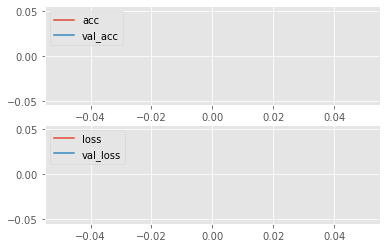

In [49]:
Train(unet)
create_acc_loss_graph(MODEL_NAME)

In [31]:
unet.eval()
outout = unet(X.to(device))

In [32]:
outout

tensor([[[[0.4857, 0.4905, 0.4913,  ..., 0.4921, 0.4897, 0.4834],
          [0.4854, 0.4871, 0.4944,  ..., 0.4928, 0.4904, 0.4897],
          [0.4800, 0.4885, 0.4919,  ..., 0.4862, 0.4871, 0.4850],
          ...,
          [0.4804, 0.4862, 0.4865,  ..., 0.4823, 0.4808, 0.4839],
          [0.4763, 0.4840, 0.4832,  ..., 0.4841, 0.4840, 0.4823],
          [0.4802, 0.4948, 0.4937,  ..., 0.4888, 0.4887, 0.4843]]],


        [[[0.4848, 0.4888, 0.4906,  ..., 0.4926, 0.4913, 0.4836],
          [0.4843, 0.4850, 0.4981,  ..., 0.4938, 0.4924, 0.4902],
          [0.4799, 0.4821, 0.4910,  ..., 0.4885, 0.4876, 0.4851],
          ...,
          [0.4756, 0.4810, 0.4876,  ..., 0.4819, 0.4793, 0.4776],
          [0.4749, 0.4859, 0.4884,  ..., 0.4819, 0.4839, 0.4813],
          [0.4847, 0.4941, 0.4933,  ..., 0.4849, 0.4872, 0.4856]]],


        [[[0.4839, 0.4874, 0.4882,  ..., 0.4888, 0.4875, 0.4831],
          [0.4836, 0.4852, 0.4906,  ..., 0.4900, 0.4876, 0.4880],
          [0.4798, 0.4861, 0.4889,  ..

In [33]:
outout.shape

torch.Size([100, 1, 64, 64])

In [35]:
outout - y.to(device)

tensor([[[[0.4857, 0.4905, 0.4913,  ..., 0.4921, 0.4897, 0.4834],
          [0.4854, 0.4871, 0.4944,  ..., 0.4928, 0.4904, 0.4897],
          [0.4800, 0.4885, 0.4919,  ..., 0.4862, 0.4871, 0.4850],
          ...,
          [0.4804, 0.4862, 0.4865,  ..., 0.4823, 0.4808, 0.4839],
          [0.4763, 0.4840, 0.4832,  ..., 0.4841, 0.4840, 0.4823],
          [0.4802, 0.4948, 0.4937,  ..., 0.4888, 0.4887, 0.4843]]],


        [[[0.4848, 0.4888, 0.4906,  ..., 0.4926, 0.4913, 0.4836],
          [0.4843, 0.4850, 0.4981,  ..., 0.4938, 0.4924, 0.4902],
          [0.4799, 0.4821, 0.4910,  ..., 0.4885, 0.4876, 0.4851],
          ...,
          [0.4756, 0.4810, 0.4876,  ..., 0.4819, 0.4793, 0.4776],
          [0.4749, 0.4859, 0.4884,  ..., 0.4819, 0.4839, 0.4813],
          [0.4847, 0.4941, 0.4933,  ..., 0.4849, 0.4872, 0.4856]]],


        [[[0.4839, 0.4874, 0.4882,  ..., 0.4888, 0.4875, 0.4831],
          [0.4836, 0.4852, 0.4906,  ..., 0.4900, 0.4876, 0.4880],
          [0.4798, 0.4861, 0.4889,  ..

In [47]:
nparr = outout.cpu()

In [50]:
nparr = nparr.detach().numpy()

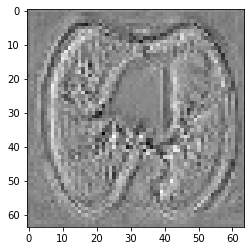

In [60]:
plt.imshow(nparr[4][0], cmap='gray')

In [134]:

# Intersection = dot(A, B)
# Union = dot(A, A) + dot(B, B)
# The Dice loss function is defined as
# 1/2 * intersection / union
#
# The derivative is 2[(union * target - 2 * intersect * input) / union^2]


def diceCoef(y_true, y_pred, smooth=1):
    intersection = torch.sum(y_true * y_pred, dim=[1,2,3])
    union = torch.sum(y_true, dim=[1,2,3]) + torch.sum(y_pred, dim=[1,2,3])
    return torch.mean( (2. * intersection + smooth) / (union + smooth), dim=0)

def diceCoefLoss(y_true, y_pred):
    return (1-diceCoef(y_true, y_pred))

def IoU_Score(y_true, y_pred, smooth=1e-8):
    intersection = torch.sum(y_true * y_pred, dim=[1,2,3])
    union = torch.sum(y_true, dim=[1,2,3]) + torch.sum(y_pred, dim=[1,2,3])
    iou_score = torch.mean( (2. * intersection + smooth) / (union + smooth), dim=0)
    return iou_score

In [135]:
loss = diceCoefLoss(outputs, y.to(device))

ious = IoU_Score(outputs, y.to(device))

In [119]:
loss

tensor(0.9988, device='cuda:0', grad_fn=<RsubBackward1>)

In [136]:
ious

tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward1>)

In [44]:
(1,2,3)

(1, 2, 3)

https://www.jeremyjordan.me/evaluating-image-segmentation-models/

https://github.com/alexanderdu15/U-Net-for-Covid-19-CT-Binary-Segmentation-in-Keras/blob/master/main/U-Net.py

https://github.com/mattmacy/vnet.pytorch/blob/master/train.py